# PGD attacks

This notebook tests **EuroSAT ResNet18 model** on images modified with **PGD attacks**.

### 1. Setup environment and imports

In [ ]:
import sys, os, re
sys.path.append(os.path.abspath(".."))

if not hasattr(sys, "frozen"):
    os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np
import tifffile
from skimage.transform import resize

from src.training.simple_cnn import SimpleCNN
from src.data.dataloader import get_dataloaders
from src.attacks.evaluate import evaluate_pgd             
from src.attacks.metrics_eval import evaluate_adv, plot_confusion_matrix  
from src.attacks.utils import select_rgb_bands, normalize_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_name = "resnet18" # or resnet18 simplecnn
data_dir = '../data/raw'
batch_size = 64

Using device: cpu


- Get path

In [2]:
if model_name == "simplecnn":
        checkpoint_path = "../experiments/checkpoints/simplecnn_best.pth"
elif model_name == "resnet18":
        checkpoint_path = "../experiments/checkpoints/resnet18_best.pth"


### 2. Load data and model

- Load dataloaders

In [3]:
train_loader, val_loader, test_loader, classes = get_dataloaders(data_dir=data_dir, batch_size=batch_size)
print(f'Loaded {len(classes)} classes: {classes}')

num_classes = len(classes)

Loaded 3 classes: ['Forest', 'Highway', 'SeaLake']


- Load model

In [4]:
if model_name.lower() == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
elif model_name.lower() == "simplecnn":
    model = SimpleCNN(num_classes=num_classes)
else:
    raise ValueError(f"Unsupported model_name: {model_name}")


- Load trained weights

In [ ]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
#model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3. Run PGD attacks and save adversarial images 

In [ ]:
out_dir = '../data/adversarial/pgd'

eps = 0.05
alpha = eps / 10
iters = 20

res = evaluate_pgd(
    model=model,
    dataloader=test_loader,
    device=device,
    eps=eps,
    alpha=alpha,
    iters=iters,
    out_dir=out_dir,
    save_every=20,
    max_save=100,
    targeted=False,
    target_class=None
)
print('PGD run result:', res)


/Users/joseantonioruizheredia/Code/Python/ml-satellite-adv/src/attacks/utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(t.mean).view(-1, 1, 1)
/Users/joseantonioruizheredia/Code/Python/ml-satellite-adv/src/attacks/utils.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(t.std).view(-1, 1, 1)
                                                             

PGD run result: {'clean_acc': 0.9913725490196078, 'adv_acc': 0.9192156862745098, 'clean_loss': 0.023697837781088023, 'adv_loss': 0.2947957197708242, 'eps': 0.05, 'saved': 59, 'out_dir': '/Users/joseantonioruizheredia/Code/Python/ml-satellite-adv/data/adversarial/pgd'}


### 4. Evaluate saved adversarial images for each epsilon

In [7]:
folder = out_dir

- Evaluation of metrics

In [8]:
print(f"\n=== Model Evaluation on Adversarial Images ===")

metrics_adv = evaluate_adv(
    adv_folder=folder,
    model_path=checkpoint_path,
    data_dir=data_dir,
    batch_size=batch_size,
    model_name=model_name,
    device=device,
    mean_std_sample_size=2000,
    image_pattern="*.tif"
)

print(f"Num images: {metrics_adv['num_images']}")

print(f"Accuracy: {metrics_adv['accuracy']*100:.2f}%")
print(f"Loss: {metrics_adv['loss']:.4f}")
print(f"Precision: {metrics_adv['precision']:.4f}")
print(f"Recall: {metrics_adv['recall']:.4f}")
print(f"F1-score: {metrics_adv['f1']:.4f}")

print("\nClassification metrics per category:\n\n", metrics_adv["classification_report"])



=== Model Evaluation on Adversarial Images ===
Num images: 145
Accuracy: 39.31%
Loss: 1.8053
Precision: 0.4590
Recall: 0.4188
F1-score: 0.3408

Classification metrics per category:

               precision    recall  f1-score   support

      Forest     0.3143    0.1833    0.2316        60
     Highway     0.6667    0.1429    0.2353        42
     SeaLake     0.3960    0.9302    0.5556        43

    accuracy                         0.3931       145
   macro avg     0.4590    0.4188    0.3408       145
weighted avg     0.4406    0.3931    0.3287       145



- Confusion Matrix

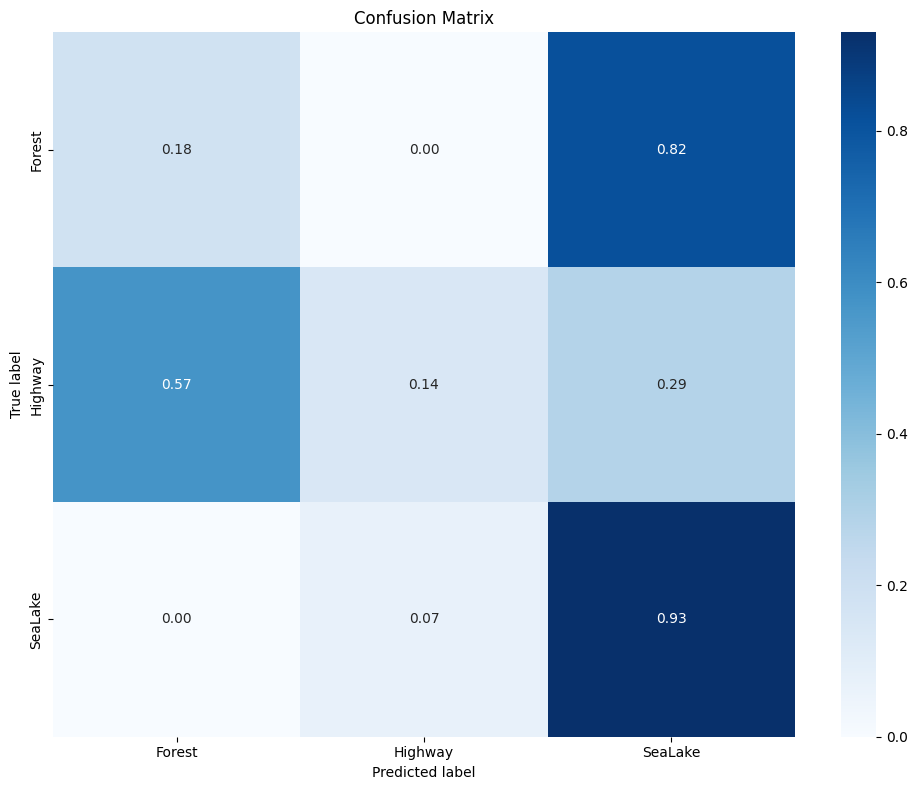

In [9]:
plot_confusion_matrix(metrics_adv['confusion_matrix'], metrics_adv['class_names'], normalize=True)

- Show a small sample of images 

NameError: name 'select_rgb_bands' is not defined

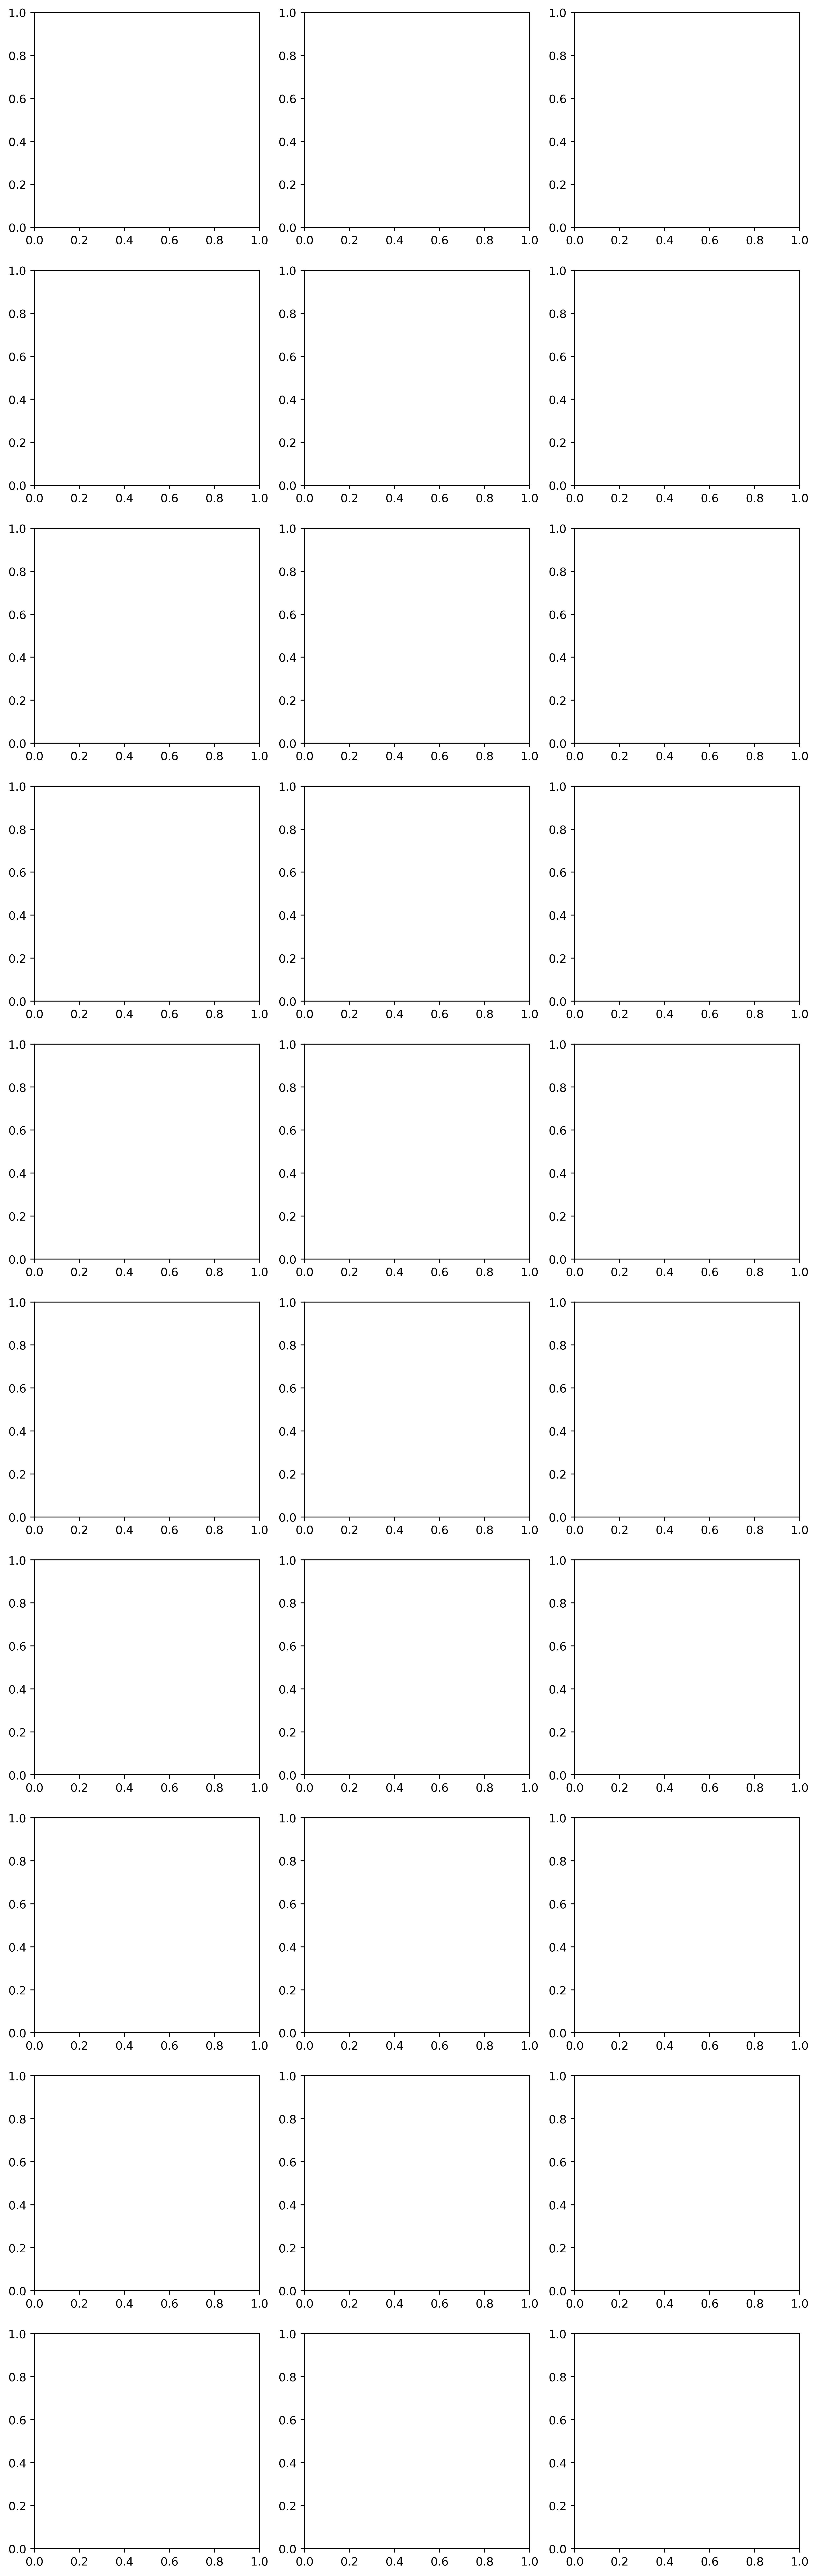

In [10]:
adv_folder = '../data/adversarial/pgd'
raw_folder = '../data/raw'
adv_paths = sorted(glob.glob(os.path.join(adv_folder, "*.tif")))

pairs = []
for adv_p in adv_paths:
    base = os.path.basename(adv_p)
    orig_base = re.sub(r"_true\d+_pred\d+\.tif$", ".tif", base)
    orig_candidates = glob.glob(os.path.join(raw_folder, "**", orig_base), recursive=True)
    if not orig_candidates:
        continue
    pairs.append((adv_p, orig_candidates[0]))

if len(pairs) == 0:
    print("No matching pairs found.")
else:
    pairs = pairs[:10]
    fig, axs = plt.subplots(len(pairs), 3, figsize=(12, 4 * len(pairs)), dpi=400)
    axs = np.atleast_2d(axs)

    for i, (adv_p, orig_p) in enumerate(pairs):
        adv = tifffile.imread(adv_p)
        orig = tifffile.imread(orig_p)
        raw_diff = np.abs(adv.astype(np.float32) - orig.astype(np.float32))

        if adv.ndim == 3 and adv.shape[0] in [3,4,13]:
            adv = np.transpose(adv, (1,2,0))
        if orig.ndim == 3 and orig.shape[0] in [3,4,13]:
            orig = np.transpose(orig, (1,2,0))

        adv_rgb = select_rgb_bands(adv)
        orig_rgb = select_rgb_bands(orig)
        if adv_rgb.shape != orig_rgb.shape:
            orig_rgb = resize(orig_rgb, adv_rgb.shape, preserve_range=True, anti_aliasing=True)

        adv_disp = normalize_image(adv_rgb)
        orig_disp = normalize_image(orig_rgb)
        diff = np.mean(np.abs(adv_disp - orig_disp), axis=2)

        p99 = np.percentile(diff, 99)
        diff_clipped = np.clip(diff / (p99 + 1e-12), 0, 1)
        scale = 0.01
        diff_vis = np.log1p(diff_clipped * scale) / np.log1p(scale)

        ax0, ax1, ax2 = axs[i]
        ax0.imshow(orig_disp)
        ax0.set_title("Original (normalized)")
        ax0.axis("off")

        ax1.imshow(adv_disp)
        ax1.set_title("Adversarial (normalized)")
        ax1.axis("off")

        im = ax2.imshow(diff_vis, cmap='hot_r', interpolation='nearest')
        ax2.set_title(f"Diff heatmap\n{os.path.basename(adv_p)}", fontsize=9)
        ax2.axis("off")

        ax2.text(
            0.99, 0.01,
            f"Normalize diff: {diff.mean():.4f}\nRaw diff: {raw_diff.mean():.4f}",
            color='white',
            fontsize=9,
            ha='right',
            va='bottom',
            transform=ax2.transAxes,
            bbox=dict(facecolor='black', alpha=0.8, pad=2)
        )

        cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.02)
        cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()